In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from surprise import SVD
from surprise import Dataset, Reader, KNNBasic,BaselineOnly
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [4]:
from scipy.sparse import csr_matrix

#### Для работы возьму датафрейм оценки музыкальных инструментов

In [5]:
df = pd.read_json('D:/Data/Musical_Instruments_5.json', lines=True)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"
...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4,Taylor Made,1404172800,"07 1, 2014"


#### Удалю ненужные колонки,оставшиеся переименую 

In [6]:
df.drop(['reviewerName', 'helpful',  'reviewText', 'summary', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [7]:
df.rename(columns={"overall": "rating", 
                   "asin": "itemID"}, inplace=True)
df

,reviewerID,itemID,rating
0,A2IBPI20UZIR0U,1384719342,5
1,A14VAT5EAX3D9S,1384719342,5
2,A195EZSQDW3E21,1384719342,5
3,A2C00NNG1ZQQG2,1384719342,5
4,A94QU4C90B1AX,1384719342,5
...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,5
10257,A1RPTVW5VEOSI,B00JBIVXGC,5
10258,AWCJ12KBO5VII,B00JBIVXGC,4
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,4


#### EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  10261 non-null  object
 1   itemID      10261 non-null  object
 2   rating      10261 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 240.6+ KB


In [9]:
df.describe()

,rating
count,10261.000000
mean,4.488744
std,0.894642
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
df.nunique()

reviewerID    1429
itemID         900
rating           5
dtype: int64

In [11]:
df.isnull().sum()

reviewerID    0
itemID        0
rating        0
dtype: int64

<AxesSubplot:>

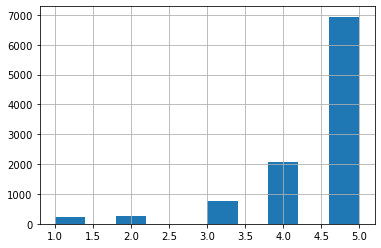

In [12]:
df.rating.hist()

In [13]:
df.rating.value_counts()

5    6938
4    2084
3     772
2     250
1     217
Name: rating, dtype: int64

#### Пропусков нет,преобладают отличные оценки

#### Распределение рейтингов по товарам 

In [134]:
data = df.groupby('itemID')['rating'].count()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


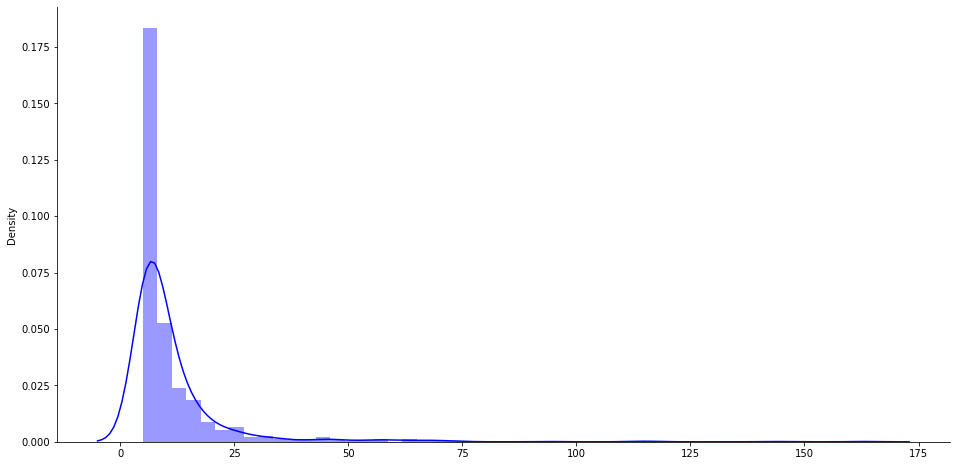

In [135]:
plt.figure(figsize=(16, 8))
sns.distplot(data.values, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

#### 10 наименований с наибольшим количеством рейтингов.

In [16]:
df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,itemID,rating
706,B003VWJ2K8,163
94,B0002E1G5C,143
156,B0002F7K7Y,116
707,B003VWKPHC,114
198,B0002H0A3S,93
44,B0002CZVXM,74
258,B0006NDF8A,71
285,B0009G1E0K,69
116,B0002E2KPC,68
167,B0002GLDQM,67


#### Распределение рейтингов по пользователям 

In [132]:
data = df.groupby('reviewerID')['rating'].count()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


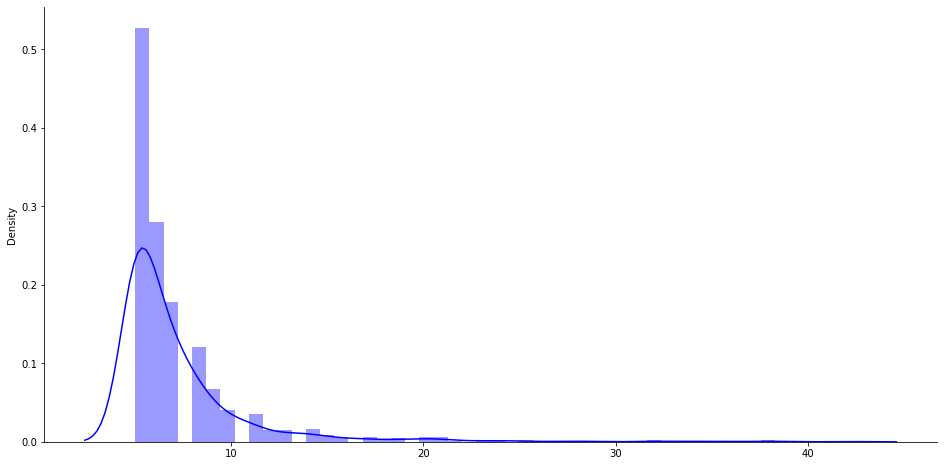

In [133]:
plt.figure(figsize=(16, 8))
sns.distplot(data.values, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

#### 10 пользователей с наибольшим количеством рейтингов.

In [19]:
df.groupby('reviewerID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,reviewerID,rating
1194,ADH0O8UVJOT10,42
218,A1L7M2JXN4EZCR,38
65,A15TYOEWBQYF0X,38
514,A2EZWZ8MBEDOLN,36
599,A2NYK9KWFMJV4Y,34
287,A1SD1C8XK3Z3V1,32
240,A1MVH1WLYDHZ49,32
170,A1GMWTGXW682GB,29
779,A34O0KQV4QXWNQ,28
225,A1LQC225SE8UNI,27


#### Построение рекомендательной системы

In [24]:
reader = Reader(rating_scale=(1, 5))
df_new = Dataset.load_from_df(df[['reviewerID', 'itemID', 'rating']], reader)

#### Для теста возьму 20%.В нашем случае это самое оптимальное значение. Модель проверю на Baseline, KNN и SVD

In [121]:
import time
trainset, testset = train_test_split(df_new, test_size=0.2, random_state=37)
results = {}

for alg in [BaselineOnly(), KNNBasic(), SVD()]:
    name = str(alg).split(' ')[0].split('.')[-1]
    
    start_time = time.time()
    predictions = alg.fit(trainset).test(testset)
    fit_test_time = time.time() - start_time
    
    acc = accuracy.rmse(predictions)
    
    results[name]=[fit_test_time,acc]

Estimating biases using als...
RMSE: 0.8827
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0041
RMSE: 0.8882


In [122]:
d = pd.DataFrame.from_dict(results)
d.index = pd.Index(['time', 'rmse'])

In [123]:
display(d)

,BaselineOnly,KNNBasic,SVD
time,0.037001,0.209012,0.792096
rmse,0.882683,1.004103,0.888166


#### Baseline сработал чуть лучше и гораздо быстрее. Вывод - для решения простых задач надо использовать простые алгоритмы 